<a href="https://colab.research.google.com/github/mtoce/DS-Unit-2-Linear-Models/blob/master/module2-regression-2/212_assig_LS_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [28]:
df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


1. Split the data in two sets.

  Train - April and May 2016

  Test - June 2016

In [0]:
# first we need to figure out how to deal with time series data

In [30]:
# looks like the 'created' column is an object. We need to convert it to datetime
df.dtypes.head()

bathrooms          float64
bedrooms             int64
created             object
description         object
display_address     object
dtype: object

In [31]:
# change 'created' column to datetime
df['created'] = pd.to_datetime(df['created'])
df.dtypes.head()

bathrooms                 float64
bedrooms                    int64
created            datetime64[ns]
description                object
display_address            object
dtype: object

In [0]:
# We are only concerned with the month of the date. So we'll just keep that
df['created'] = df['created'].dt.month

In [52]:
# check to see what months were dealing with. Oh its just our 3 from the question.
df['created'].value_counts()

6    16973
4    16217
5    15627
Name: created, dtype: int64

In [0]:
# Let's create our training and testing data

# TRAIN - April and May DF
train = df[df['created'] < 6]

# TEST - June DF
test = df[df['created'] == 6]

In [0]:
# Start with baselines (no features) - Just our Target or Y-variable
target = 'price'
y_train = train[target]
y_test = test[target]

In [61]:
# Get the baseline mean -> in this case, since our target is categorical, we
# want our baseline to be the mode. Although we could map 0 1 and 2 to these
# categories to gauge interest level
baseline = y_train.mean()
baseline

3575.604007034292

In [65]:
# Train error
from sklearn.metrics import mean_absolute_error
y_pred = [baseline] * len(y_train)
mae = mean_absolute_error(y_train, y_pred)
print('Train error (April & May apt. info):', mae, '%')

Train error (April & May apt. info): 1201.8811133682555 %


In [64]:
# Test error
y_pred = [baseline] * len(y_test)
mae = mean_absolute_error(y_test, y_pred)
print('Test error (June apt. info):', mae,'%')

Test error (June apt. info): 1197.7088871089013 %


In [0]:
# import a class from sklearn
from sklearn.linear_model import LinearRegression

In [0]:
# call the regression function
model = LinearRegression()

In [66]:
# define our features

features= ['dogs_allowed', 'cats_allowed']
X_train = train[features]
X_test = test[features]
print('Linear Regression dependent on these features:', features)

Linear Regression dependent on these features: ['dogs_allowed', 'cats_allowed']


In [82]:
# fit the model
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print('Train Error:', mae)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Train Error: 1197.3520771096757


In [71]:
# apply model to new test data
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print('Test Error:', mae)

Test Error: 1194.168712367809


In [80]:
# if dogs are allowed, the price increases on average by $345 whereas if cats are allowed
# the price decreases by $138. 
model.coef_

array([ 345.83111135, -138.11834996])

In [0]:
# The model is not much better than the baseline, but it is slightly better

In [0]:
# lets define a function to do our future linear regressions for us!
def linear_regression(test, train, target, features):
  # set target, get baseline, and base error
  y_train = train[target]
  y_test = test[target]
  baseline = y_train.mean()
  y_pred = [baseline] * len(y_train)
  baseline_train_mae = mean_absolute_error(y_train, y_pred)
  y_pred = [baseline] * len(y_test)
  baseline_test_mae = mean_absolute_error(y_test, y_pred)
  # import regression
  from sklearn.metrics import mean_absolute_error
  from sklearn.linear_model import LinearRegression
  # call regression
  model = LinearRegression()
  # declare features
  X_train = train[features]
  X_test = test[features]
  # fit the model to train data
  model.fit(X_train, y_train)
  y_pred = model.predict(X_train)
  train_mae = mean_absolute_error(y_train, y_pred)
  # apply model to new test data
  y_pred = model.predict(X_test)
  test_mae = mean_absolute_error(y_test, y_pred)
  return baseline_train_mae, baseline_test_mae, train_mae, test_mae

In [0]:
def regression_3d(df, x, y, z, num=100, **kwargs):
    """
    Visualize linear regression in 3D: 2 features + 1 target
    
    df : Pandas DataFrame
    x : string, feature 1 column in df
    y : string, feature 2 column in df
    z : string, target column in df
    num : integer, number of quantiles for each feature
    """
    
    # Plot data
    fig = px.scatter_3d(df, x, y, z, **kwargs)
    
    # Fit Linear Regression
    features = [x, y]
    target = z
    model = LinearRegression()
    model.fit(df[features], df[target])    
    
    # Define grid of coordinates in the feature space
    xmin, xmax = df[x].min(), df[x].max()
    ymin, ymax = df[y].min(), df[y].max()
    xcoords = np.linspace(xmin, xmax, num)
    ycoords = np.linspace(ymin, ymax, num)
    coords = list(itertools.product(xcoords, ycoords))
    
    # Make predictions for the grid
    predictions = model.predict(coords)
    Z = predictions.reshape(num, num).T
    
    # Plot predictions as a 3D surface (plane)
    fig.add_trace(go.Surface(x=xcoords, y=ycoords, z=Z))
    
    return fig

In [0]:
import itertools
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
from sklearn.linear_model import LinearRegression
regression_3d(train,
              x='dogs_allowed',
              y='cats_allowed',
              z='price',
              )

In [0]:
# from the graph above, we can see that the apartments with cats allowed and no dogs give us cheaper on average, then none for either, then both, then just dogs allowed.

In [0]:
# Let's look at some new features. Latitude and longitude!


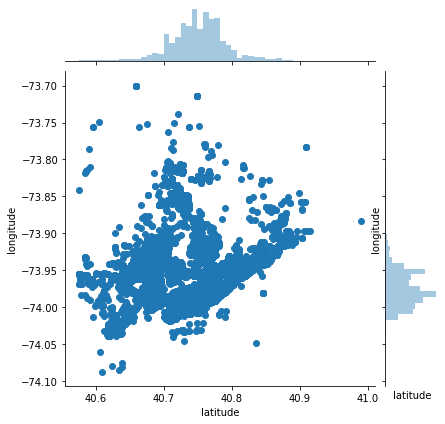

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.jointplot(x=df['latitude'], y=df['longitude'])
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.show()

In [0]:
# can we separate into 5 burrows based on lat/lon